# Data cleaning


In [15]:
# Initial imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
from path import Path
from sklearn.metrics import silhouette_score

%matplotlib inline

In [3]:
# Loading data
data = pd.read_csv(Path("Resources/Health_systems.csv"))

In [4]:
# Drop columns due to lack of data
data_df = data.drop(
    columns=['Country_Region', 'Province_State', 
             'Completeness_of_birth_reg_2009-18', 'Specialist_surgical_per_1000_2008-18', 
             'Nurse_midwife_per_1000_2009-18', 'Physicians_per_1000_2009-18'], 
    axis=1
)

# Make column names more readable
data_df.rename(
    columns={"Health_exp_pct_GDP_2016": "Health expenditure (% of GDP)",
            "Health_exp_public_pct_2016": "Domestic general government health expenditure (% of health expenditure)",
            "Health_exp_out_of_pocket_pct_2016": "Out-of-pocket expenditure (% of health expenditure)",
            "Health_exp_per_capita_USD_2016": "Health expenditure per capita (current US$)",
            "per_capita_exp_PPP_2016": "Current health expenditure per capita, PPP (current international $)",
            "External_health_exp_pct_2016": "External health expenditure (% of current health expenditure)"},
    inplace=True
)

In [ ]:
# Count nulls in each column
# data_df.isnull().sum()

# Slice rows with null values out of original DataFrame
# df1 = data_df[data_df.isnull().any(axis=1)] 

In [4]:
# Drop rows with null values in particular column
data_df.dropna(
    subset=['Health expenditure (% of GDP)'], 
    inplace=True
)

# Fill missing values with 0 for other rows and columns
data_df.fillna(
    value=0, 
    inplace=True
)

In [5]:
# Fetch country names for later use
names = data_df['World_Bank_Name']

In [7]:
# Encode Completeness of death registration column as 0/1 values with 0 for either missing 
# or lower than the threshold of 98% and 1 for value above the threshold,
# we assume this indicates policital transparency of healthcare systems
data_df['Transparency'] = data_df['Completeness_of_death_reg_2008-16'] > 98

# Convert boolean array to numerical 
data_df['Transparency'] = data_df['Transparency'].astype(int)

# Drop original column containing scores and null values
data_df.drop('Completeness_of_death_reg_2008-16',axis=1, inplace=True)

In [26]:
# See how data looks at this point
data_df.set_index('World_Bank_Name', inplace=True)
data_df.head()

,Health expenditure (% of GDP),Domestic general government health expenditure (% of health expenditure),Out-of-pocket expenditure (% of health expenditure),Health expenditure per capita (current US$),"Current health expenditure per capita, PPP (current international $)",External health expenditure (% of current health expenditure),Transparency
World_Bank_Name,,,,,,,
Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0
Albania,6.7,41.4,58.0,271.5,759.7,0.7,0
Algeria,6.6,67.7,30.9,260.4,998.2,0.0,0
Andorra,10.4,49.1,41.7,3834.7,4978.7,0.0,0
Angola,2.9,44.1,35.2,95.2,185.8,3.6,0


In [30]:
aid = data_df.loc[data_df['External health expenditure (% of current health expenditure)'] > 0]

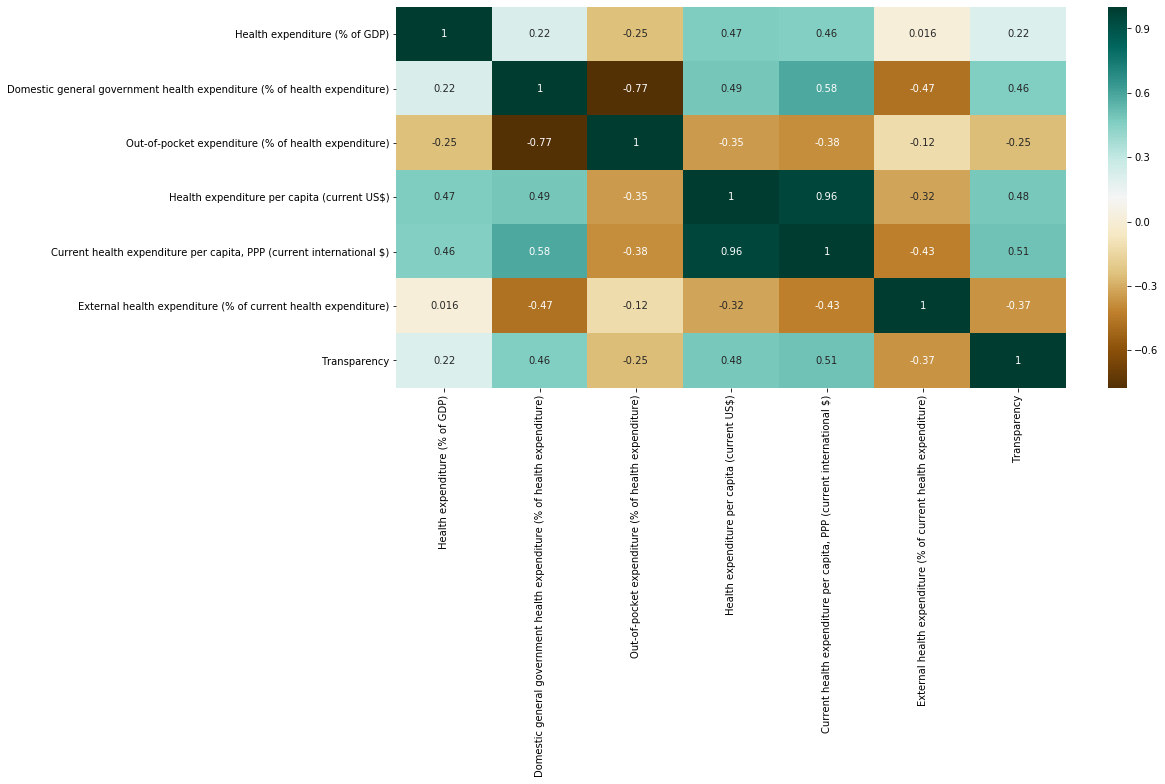

In [9]:
# Finding the relations between the variables in clean Df
corr = data_df.corr()

# Plot heatmap with seaborn
plt.figure(figsize=(15,7))
sns.heatmap(corr,cmap='BrBG',annot=True)

# Data pre-processing

In [10]:
# Create new DF to process and fit to model
data_kmeans = data_df.copy()

## Data scaling with StandardScaler

In [11]:
# Normalize data with StandardScaler class
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and scale 
data_kmeans_scaled = scaler.fit_transform(data_kmeans)

# Look at the array
print(len(data_kmeans_scaled))

186


## Data compressing with PCA

In [12]:
# Compress data using PCA class
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# Fit scaled data and compress to three dimensions
data_pca = pca.fit_transform(data_kmeans_scaled)

# Transform PCA output to DF
data_pca_df = pd.DataFrame(
        data=data_pca,
        columns=['PC 1', 'PC 2', 'PC 3']
)

# Add country names to compressed df
data_pca_df.set_index(names, inplace=True)

# Look at the result
print(data_pca_df.head(10),"\n")

# Fetch variance explained by three dimensions
print(f"Explained variance after applying PCA: {pca.explained_variance_ratio_.sum()}")

                         PC 1      PC 2      PC 3
World_Bank_Name                                  
Afghanistan         -2.385827 -0.531773  2.592451
Albania             -1.120018 -1.018144  0.502206
Algeria             -0.088456 -0.115044 -0.682784
Andorra              1.821418 -0.446902  1.983478
Angola              -1.309290 -0.517869 -0.899646
Antigua and Barbuda -0.367960 -0.437397 -0.896599
Argentina            1.482788 -0.048754 -0.918832
Armenia             -1.651553 -1.460902  2.257282
Australia            3.440384 -0.280855  0.833723
Austria              3.758958 -0.177187  1.010274 

Explained variance after applying PCA: 0.8316723331136312


## K-Means

In [14]:
# Initializing model with K = 4
model_4 = KMeans(
    n_clusters=4, 
    random_state=5
)

# Initializing model with K = 5
model_5 = KMeans(
    n_clusters=5, 
    random_state=5
)

# Initializing model with K = 6
model_6 = KMeans(
    n_clusters=6,
    random_state=5
)

In [22]:
# Display entire DataFrame
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#     display(data_kmeans)

# Display only certain cluster
# data_kmeans.loc[data_kmeans['Cluster'] == 1]

In [23]:
# Fitting model 5 with scaled and compressed data
model_5.fit(data_pca)

# Get predictions of scaled and compressed data
predictions_5_pca = model_5.predict(data_pca)

In [24]:
# Add new clusters PCA column to DF 
data_kmeans['Cluster'] = model_5.labels_

# Visualization

In [25]:
# Concat data into single df for visualization 
df_for_vis = pd.concat(
    [data_kmeans, data_pca_df], 
    axis=1, 
    join='inner'
)

## 3D-Scatter

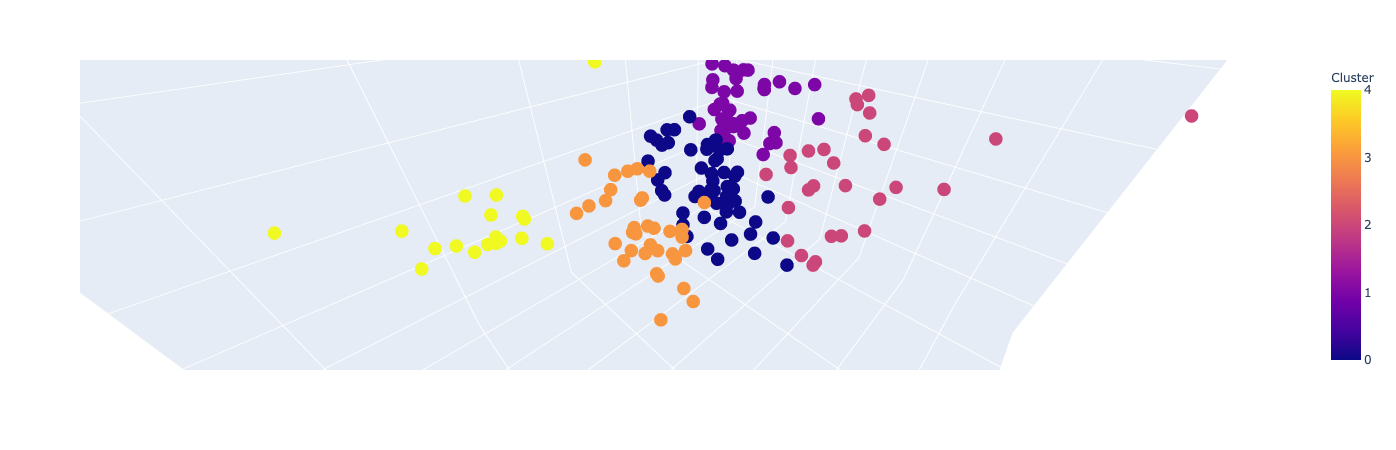

In [26]:
# Create a 3D-Scatter with the PCA data and the clusters
scatter3d = px.scatter_3d(
    df_for_vis,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    width=600,
    color='Cluster',
    hover_name = names
)

scatter3d.update_layout(legend=dict(x=0, y=1))
scatter3d.show()

# Clustering evaluation

In [27]:
# Idea for health development level score

# Mean for expenditure per capita is 1037
data_kmeans["Health expenditure per capita (current US$)"].describe()

# Assign either high or low IF value is above or below 1037 for health expediture per capita
data_kmeans['Health systems development level']=["High" if i>1037 else "Low" for i in data_kmeans['Health expenditure per capita (current US$)']]

# Print value count for both groups
print(data_kmeans['Health systems development level'].value_counts(dropna=False))

Low     137
High     49
Name: Health systems development level, dtype: int64


In [28]:
# Look at the distribution of values sorted by healh systems development level 
# data_kmeans.boxplot(column='Health expenditure per capita (current US$)',by='Health systems development level',figsize=(6,12))

In [29]:
# Assign new value based on defined 
data_kmeans['Category']=["Best" if i>8000 else "Good" if 4000<i<8000 else "Average" if 2000<i<4000 else "Bad" if 1000<i<2000 else "Worst" for i in data_kmeans['Health expenditure per capita (current US$)']]

# Print value count for both groups
print(data_kmeans['Category'].value_counts(dropna=False))

Worst      136
Bad         22
Good        15
Average     11
Best         2
Name: Category, dtype: int64


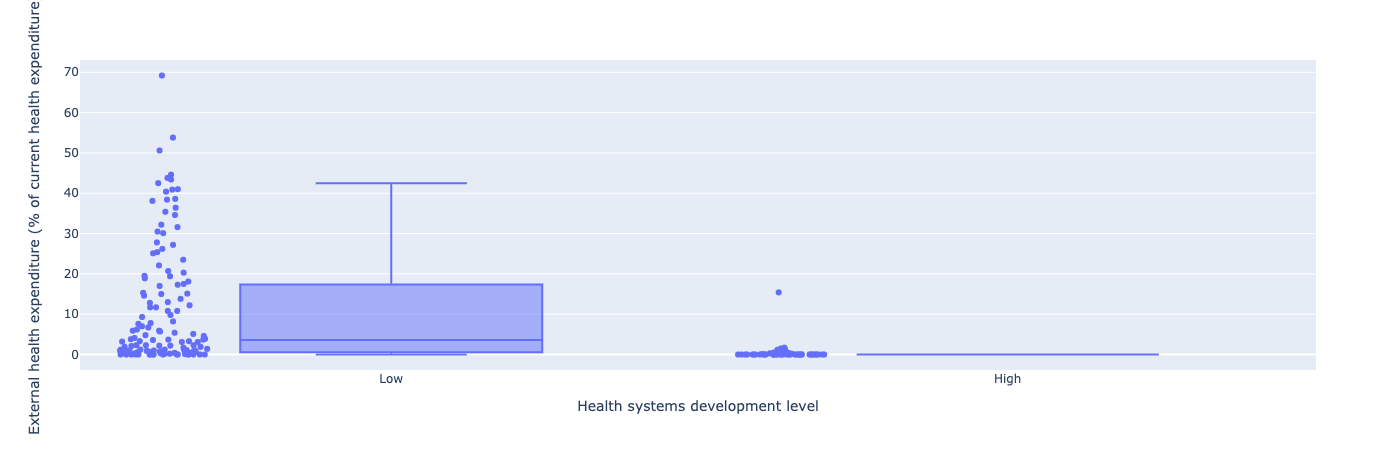

In [30]:
# Box plot to see the spread 
px.box(
    data_kmeans, 
    y='External health expenditure (% of current health expenditure)', 
    x='Health systems development level', 
    points='all'
)